<a href="https://colab.research.google.com/github/sayevvv/PBL_MoneyClassification/blob/main/PBL_PreprocessingV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PBL - MONEY DETECTION

#PREPROCESSING DATA V2
 Metode:
- Preprocessing: Resize, Gaussian Blur, Konversi BGR ke HSV & Grayscale
- Ekstraksi Fitur (Gabungan):
    1. Fitur Warna: Histogram (Hue + Saturation)
    2. Fitur Tekstur: Local Binary Patterns (LBP)
    3. Fitur Bentuk: Hu Moments
- Output: File .joblib v2 baru (tidak menimpa yang lama)

In [1]:
# -----------------------------------------------------
# LANGKAH 1: IMPORT LIBRARY DAN MOUNT DRIVE
# -----------------------------------------------------
!pip install scikit-image

import os
import cv2
import numpy as np
import joblib
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern # Untuk Fitur Tekstur (LBP)

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# -----------------------------------------------------
# LANGKAH 2: KONFIGURASI DAN DEFINISI VARIABEL
# -----------------------------------------------------

# Path utama (tetap sama)
BASE_DIR = '/content/drive/MyDrive/tugas_akhir_semester5/raw_data'
LABELS = ['1000', '2000', '5000', '10000', '20000', '50000', '100000']
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

# --- Parameter Preprocessing ---
IMG_SIZE = (250, 250)

# --- Parameter Fitur Warna (HSV) ---
H_BINS = 180
S_BINS = 256

# --- Parameter Fitur Tekstur (LBP) ---
# P (Points): Jumlah tetangga
# R (Radius): Jarak tetangga
LBP_POINTS = 24
LBP_RADIUS = 8
# Jumlah bin LBP akan menjadi LBP_POINTS + 2 = 26 (karena method 'uniform')
LBP_BINS = int(LBP_POINTS + 2)

print(f"Path utama diatur ke: {BASE_DIR}")
print(f"Kelas yang akan diproses: {LABELS}")
print(f"Fitur Vektor = Warna ({H_BINS + S_BINS}) + Tekstur ({LBP_BINS}) + Bentuk (7)")


Path utama diatur ke: /content/drive/MyDrive/tugas_akhir_semester5/raw_data
Kelas yang akan diproses: ['1000', '2000', '5000', '10000', '20000', '50000', '100000']
Fitur Vektor = Warna (436) + Tekstur (26) + Bentuk (7)


In [3]:
# -----------------------------------------------------
# LANGKAH 3: FUNGSI EKSTRAKSI FITUR V2 (MULTI-FITUR)
# -----------------------------------------------------

def extract_features_v2(image_path):
    """
    Fungsi ini mengambil satu path gambar, melakukan preprocessing,
    dan mengekstrak gabungan fitur (Warna, Tekstur, Bentuk).
    """
    try:
        # 1. Baca gambar
        image = cv2.imread(image_path)
        if image is None:
            print(f"Peringatan: Tidak bisa membaca gambar {image_path}. Dilewati.")
            return None

        # --- PREPROCESSING GAMBAR ---

        # 2. Resize dan Blur
        image = cv2.resize(image, IMG_SIZE)
        image = cv2.GaussianBlur(image, (5, 5), 0)

        # 3. Konversi Ruang Warna (kita butuh HSV dan Grayscale)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # --- FITUR 1: WARNA (HSV HISTOGRAM) ---
        h_hist = cv2.calcHist([hsv_image], [0], None, [H_BINS], [0, 180])
        s_hist = cv2.calcHist([hsv_image], [1], None, [S_BINS], [0, 256])

        # Normalisasi (PERBAIKAN DITERAPKAN)
        # Kita atur 'dst' (parameter kedua) ke None agar OpenCV membuat array baru
        h_hist = cv2.normalize(h_hist, None, 0, 1, cv2.NORM_MINMAX)
        s_hist = cv2.normalize(s_hist, None, 0, 1, cv2.NORM_MINMAX)

        color_features = np.concatenate((h_hist, s_hist)).flatten()

        # --- FITUR 2: TEKSTUR (LBP) ---
        # Gunakan method 'uniform' agar fitur LBP robust thd rotasi
        lbp = local_binary_pattern(gray_image, LBP_POINTS, LBP_RADIUS, method='uniform')

        # Hitung histogram dari hasil LBP
        (texture_features, _) = np.histogram(lbp.ravel(),
                                             bins=LBP_BINS,
                                             range=(0, LBP_BINS))

        # Normalisasi (PERBAIKAN DITERAPKAN)
        # Sama, kita atur 'dst' ke None
        texture_features = cv2.normalize(texture_features, None, 0, 1, cv2.NORM_MINMAX)

        # --- PERBAIKAN LANGKAH INI (MENGATASI ERROR DIMENSI) ---
        # Kita ratakan (flatten) hasilnya agar menjadi 1D array,
        # sama seperti color_features dan shape_features
        texture_features = texture_features.flatten()

        # --- FITUR 3: BENTUK (HU MOMENTS) ---
        # Kita butuh gambar biner (hitam-putih) untuk Hu Moments
        # Gunakan Otsu's thresholding untuk memisahkan objek dari background
        _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Hitung moments
        moments = cv2.moments(thresh)

        # Hitung Hu Moments
        hu_moments = cv2.HuMoments(moments)

        # Log-transform Hu Moments agar stabil (best practice)
        shape_features = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-7)
        shape_features = shape_features.flatten()

        # --- GABUNGKAN SEMUA FITUR ---
        final_feature_vector = np.concatenate((color_features, texture_features, shape_features))

        return final_feature_vector

    except Exception as e:
        print(f"Error memproses {image_path}: {e}")
        return None

In [4]:
# -----------------------------------------------------
# LANGKAH 4: CEK KESEIMBANGAN DATA
# -----------------------------------------------------
# (Fungsi ini sama persis dengan skrip sebelumnya)

print("\nMemulai pengecekan keseimbangan data...")
data_counts = {}
total_images = 0

for label in LABELS:
    label_path = os.path.join(BASE_DIR, label)
    if not os.path.isdir(label_path):
        data_counts[label] = 0
        continue
    count = 0
    for file in os.listdir(label_path):
        if file.lower().endswith(VALID_EXTENSIONS):
            count += 1
    data_counts[label] = count
    total_images += count

print("\n--- Laporan Keseimbangan Data ---")
if total_images == 0:
    print("PERINGATAN: Tidak ada gambar yang ditemukan!")
else:
    for label, count in data_counts.items():
        percentage = (count / total_images) * 100
        print(f"Kelas: {label.ljust(10)} | Jumlah: {str(count).ljust(5)} | Persentase: {percentage:.2f}%")
print(f"Total Gambar: {total_images}")
print("---------------------------------")


Memulai pengecekan keseimbangan data...

--- Laporan Keseimbangan Data ---
Kelas: 1000       | Jumlah: 240   | Persentase: 14.54%
Kelas: 2000       | Jumlah: 240   | Persentase: 14.54%
Kelas: 5000       | Jumlah: 224   | Persentase: 13.57%
Kelas: 10000      | Jumlah: 240   | Persentase: 14.54%
Kelas: 20000      | Jumlah: 240   | Persentase: 14.54%
Kelas: 50000      | Jumlah: 227   | Persentase: 13.75%
Kelas: 100000     | Jumlah: 240   | Persentase: 14.54%
Total Gambar: 1651
---------------------------------


In [5]:
# -----------------------------------------------------
# LANGKAH 5: PROSES SELURUH DATASET
# -----------------------------------------------------

if total_images > 0:
    print("\nMemulai pemrosesan dataset dan ekstraksi multi-fitur (v2)...")

    data_features = []
    data_labels = []

    for label in LABELS:
        label_path = os.path.join(BASE_DIR, label)

        if not os.path.isdir(label_path) or data_counts[label] == 0:
            continue

        print(f"\nMemproses folder: {label}")
        image_files = os.listdir(label_path)

        for image_file in tqdm(image_files, desc=f"Kelas {label}"):
            if image_file.lower().endswith(VALID_EXTENSIONS):
                full_path = os.path.join(label_path, image_file)

                # Panggil fungsi V2 baru kita
                features = extract_features_v2(full_path)

                if features is not None:
                    data_features.append(features)
                    data_labels.append(label)

    print("\n...Pemrosesan V2 selesai.")

else:
    print("\nEkstraksi fitur dilewati karena tidak ada data yang ditemukan.")
    data_features = []


Memulai pemrosesan dataset dan ekstraksi multi-fitur (v2)...

Memproses folder: 1000


Kelas 1000: 100%|██████████| 240/240 [00:27<00:00,  8.76it/s]



Memproses folder: 2000


Kelas 2000: 100%|██████████| 240/240 [00:51<00:00,  4.65it/s]



Memproses folder: 5000


Kelas 5000: 100%|██████████| 224/224 [00:38<00:00,  5.80it/s]



Memproses folder: 10000


Kelas 10000: 100%|██████████| 240/240 [00:26<00:00,  9.05it/s]



Memproses folder: 20000


Kelas 20000: 100%|██████████| 240/240 [00:17<00:00, 13.74it/s]



Memproses folder: 50000


Kelas 50000: 100%|██████████| 229/229 [00:26<00:00,  8.77it/s]



Memproses folder: 100000


Kelas 100000: 100%|██████████| 240/240 [00:41<00:00,  5.78it/s]


...Pemrosesan V2 selesai.


In [7]:
# -----------------------------------------------------
# LANGKAH 6: SIMPAN HASIL V2 (NAMA FILE BARU)
# -----------------------------------------------------

if not data_features:
    print("Tidak ada data yang diproses. File .joblib tidak akan dibuat.")
else:
    X = np.array(data_features)
    y = np.array(data_labels)

    print(f"\nBentuk (shape) data fitur (X) v2: {X.shape}")
    print(f"Bentuk (shape) data label (y) v2: {y.shape}")

    # --- NAMA FILE BARU UNTUK VERSI INI ---
    save_path_X = os.path.join(BASE_DIR, 'features_X_v2.joblib')
    save_path_y = os.path.join(BASE_DIR, 'labels_y_v2.joblib')

    joblib.dump(X, save_path_X)
    joblib.dump(y, save_path_y)

    print(f"\nData fitur V2 berhasil disimpan di: {save_path_X}")
    print(f"Data label V2 berhasil disimpan di: {save_path_y}")
    print("\nAnda sekarang siap melatih model SVM/XGBoost pada fitur V2!")


Bentuk (shape) data fitur (X) v2: (1651, 469)
Bentuk (shape) data label (y) v2: (1651,)

Data fitur V2 berhasil disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/features_X_v2.joblib
Data label V2 berhasil disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/labels_y_v2.joblib

Anda sekarang siap melatih model SVM/XGBoost pada fitur V2!



Visualisasi contoh V2:


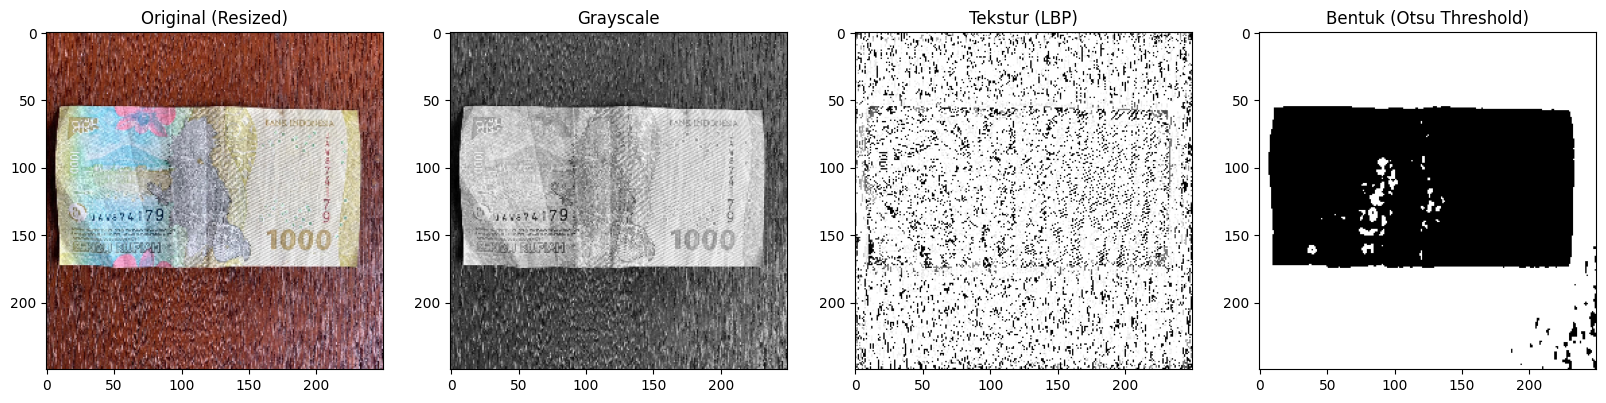

In [6]:
# -----------------------------------------------------
# LANGKAH 7: (OPSIONAL) VISUALISASI CONTOH V2
# -----------------------------------------------------

if total_images > 0:
    print("\nVisualisasi contoh V2:")
    try:
        # Ambil satu gambar contoh
        sample_label = LABELS[0]
        sample_img_name = os.listdir(os.path.join(BASE_DIR, sample_label))[0]
        sample_path = os.path.join(BASE_DIR, sample_label, sample_img_name)

        # Baca dan proses
        img = cv2.imread(sample_path)
        img_resized = cv2.resize(img, IMG_SIZE)
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

        # Hitung LBP dan Threshold
        lbp = local_binary_pattern(img_gray, LBP_POINTS, LBP_RADIUS, method='uniform')
        _, thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Tampilkan
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        axs[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original (Resized)')

        axs[1].imshow(img_gray, cmap='gray')
        axs[1].set_title('Grayscale')

        axs[2].imshow(lbp, cmap='gray')
        axs[2].set_title('Tekstur (LBP)')

        axs[3].imshow(thresh, cmap='gray')
        axs[3].set_title('Bentuk (Otsu Threshold)')

        plt.show()

    except Exception as e:
        print(f"Tidak bisa membuat visualisasi: {e}")